<div style="background-color:#7a1400;height:60px;padding-top:7px;">
<h3 align=center style="color:white">
Multivariate Sales Forecasting - German Retail Chain - Multivariate Forecasting
</h3> 
</div>

<h4>Avinash Pasupulate</h4><br>
avinash.pasupulate@gmail.com<br>
<a href="www.avinash.pasupulate.com">www.avinash.pasupulate.com</a>
<br><br>
<i>7th January 2019</i>

<br>
<hr>
<b>Open the html file in the repository or click 
<a href="http://nbviewer.jupyter.org/github/avinashpasupulate/multivariate_sales_forecasting_german_retail_chain/blob/master/sales_forecasting.ipynb">Nbconvert Notebook</a> to view plots that are properly rendered.
<br><br>
Please wait for the html page to load completely.</b>
<br>
<hr>

<h3>Methods for Multivariate Forecasting: </h3>
<hr>
<ul>
    <li> Linear Regression
    <li> ARIMAX - Auto-Regressive Integrated Moving Average with Exogenous variables
    <li> SARIMAX - Seasonal Auto-Regressive Integrated Moving Average with Exogenous variables
    <li> VAR - Vector AutoRegression
    <li> Prophet by Facebook
     </ul>
<br><br>       
 
 
<h3>Steps to Complete: </h3>
<hr>
<ul>
    <li> Clean-up & remove/replace null values

In [829]:
import os
import copy
import warnings
import random #setting seed

#data 
import datetime as dt
import pandas as pd
import numpy as np


#visualization
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm._tqdm_notebook import tqdm_notebook

#data pre-processing
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

#forecasting
from fbprophet import Prophet
from sklearn.linear_model import LinearRegression


% matplotlib inline
tqdm_notebook.pandas()
warnings.filterwarnings('ignore')
pd.set_option('float_format','{:f}'.format)

In [449]:
cwd = os.getcwd()
random.seed(9891482)

In [450]:
forecast_ads = pd.read_csv(cwd+r'/data/processed_data/sales_ads.csv')

<h3>Data Cleanup</h3>
<hr>
<ul>
    <li> Check for missing and partial values
    <li> Replace / correct missing or partial values
    <li> Remove rows containing NA values
    <li> Final Checks
</ul>

In [451]:
#making copy of the imported data
forecast_clean = copy.deepcopy(forecast_ads)

In [452]:
#checking for missing and partial information
num = forecast_clean.describe(include='all').T
num['count']=num['count'].astype('int64')
num[['count', 'unique']].sort_values('count', ascending=True)

count unique
CompetitionDistance     2611969    NaN
Unnamed: 0              2617643    NaN
days_since_competition  2617643   9461
Assortment              2617643      3
StoreType               2617643      4
relh                    2617643    NaN
tmpc                    2617643    NaN
cpi                     2617643    NaN
num_asy_app             2617643     31
wc_days                 2617643    NaN
google_svi              2617643    NaN
mapped_region           2617643     12
quarter                 2617643    NaN
days_since_promo2       2617643   2183
seasons                 2617643      4
weekday                 2617643      7
iso_weeknum             2617643    NaN
day                     2617643    NaN
year                    2617643    NaN
SchoolHoliday           2617643    NaN
StateHoliday            2617643      4
Promo                   2617643    NaN
Open                    2617643    NaN
Customers               2617643    NaN
Sales                   2617643    NaN
date_s                  2617643    942
Store                   2617643    NaN
month                   2617643     12
promo2_int_mod          2617643    NaN

In [453]:
num[['count', 'unique']][num['unique']<10]

count unique
StateHoliday  2617643      4
weekday       2617643      7
seasons       2617643      4
StoreType     2617643      4
Assortment    2617643      3

In [454]:
#replacing na values in the CompetitionDistance column with 0 
forecast_clean.loc[forecast_clean['CompetitionDistance'].isna(),
                   'CompetitionDistance']=0

In [455]:
#replace timedelta values with numbers in days_since_competition and days_since_promo2 columns
forecast_clean['days_since_competition'] = pd.to_timedelta(forecast_clean['days_since_competition']).dt.days
forecast_clean['days_since_promo2'] = pd.to_timedelta(forecast_clean['days_since_promo2']).dt.days


In [456]:
#list all datatypes in forecast_clean dataframe
forecast_clean.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2617643 entries, 0 to 2617642
Data columns (total 29 columns):
Unnamed: 0                int64
Store                     int64
date_s                    object
Sales                     int64
Customers                 int64
Open                      int64
Promo                     int64
StateHoliday              object
SchoolHoliday             int64
year                      int64
day                       int64
iso_weeknum               int64
weekday                   object
month                     object
seasons                   object
quarter                   int64
mapped_region             object
google_svi                int64
wc_days                   int64
num_asy_app               object
cpi                       float64
tmpc                      float64
relh                      float64
StoreType                 object
Assortment                object
CompetitionDistance       float64
days_since_competition    int64
days_s

In [457]:
#convert datatypes
forecast_clean['Store'] = forecast_clean['Store'].astype(str)
forecast_clean.loc[forecast_clean['StateHoliday']!='0', 'StateHoliday'] = 1
forecast_clean['SchoolHoliday'] = forecast_clean['SchoolHoliday'].astype(int)
forecast_clean['StateHoliday'] = forecast_clean['StateHoliday'].astype(int)
forecast_clean['num_asy_app'] = (forecast_clean['num_asy_app'].apply(lambda x: x.replace(',','').replace('.',''))).astype(float)
#remove date columns since they are captured separately

In [458]:
#datetime object can also be converted to ordinal values line "701234" using the below code
#pd.to_datetime(forecast_ads['date_s']).map(dt.datetime.toordinal)

In [459]:
#converting date to ordinal
#removing store type and assortment since these variables are at the store level
#also excluding season because temperature and humidity can be used to simulate the same
weekdaymap = {'Friday':6, 'Thursday':5, 'Wednesday':4, 'Tuesday':3, 'Monday':2, 'Sunday':1,
       'Saturday':7}
forecast_clean['month'] = forecast_clean['month'].apply(lambda x: int(dt.datetime.strptime(x, '%B').month))
forecast_clean['weekday'] = forecast_clean['weekday'].map(weekdaymap).astype(int)

forecast_clean.drop(['StoreType', 'Assortment','seasons'], inplace=True, axis=1)


In [848]:
def mape(y_true, y_pred):
    t_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs(y_true - y_pred) / np.abs(y_true)) * 100

<h3>Linear Regression</h3>
<hr>
<ul>
    <li> One Hot Encoding
    <li> Train, Validation & Test Split
    <li> Feature Selection & run model
        <ul>
            <li> Backward Feature Selection
            <li> Forward Feature Selection
            <li> Stepwise Feature Selection
        </ul>
    <li> Validate model using validation dataset
    <li> Optimize Parameters to get an ideal fit for validation dataset
    <li> Test with test dataset
    <li> Intepret results
</ul>
<br>
<h4>Notes:</h4>
<ul>
    <li> Maynot be an ideal method to forecast a timeseries
    <li> Check from multi-collinearity
    <li> Check for missing or incomplete data
    <li> Check for outliers
    <li> Ensure data splits are made in sequence since this for a time series
</ul>
<br>
<h4>Reference:</h4> 
<ul>
    <li><a href="https://www.theanalysisfactor.com/13-steps-regression-anova/">13 Steps for Regression ANOVA</a>

In [460]:
#creating copy for linear regression
linear_ds = copy.deepcopy(forecast_clean)
linear_ds.head()
linear_ds.drop('date_s', inplace=True, axis = 1)

In [461]:
#testing with one store
def store_set(linear_ds, store):
    #subsetting data by store
    store1 = linear_ds.loc[linear_ds['Store']==store]
    store1.drop(['Store','Unnamed: 0','mapped_region'], inplace=True, axis=1)
    #One Hot Encoding
    store1 = pd.get_dummies(store1)
    return store1

In [871]:
#running func with one hot encoding
store='1'
store1 = store_set(linear_ds, store)
len(store1)

1884

In [872]:
store1.columns

Index(['Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday',
       'year', 'day', 'iso_weeknum', 'weekday', 'month', 'quarter',
       'google_svi', 'wc_days', 'num_asy_app', 'cpi', 'tmpc', 'relh',
       'CompetitionDistance', 'days_since_competition', 'days_since_promo2',
       'promo2_int_mod'],
      dtype='object')

In [873]:
len(store1.columns)

22

<h4>Seasonality Index</h4>
<br>
Calculating seasonality index with month data since the data data is excluded

In [874]:
#sum(day sales for all years) / sum(overall sales)

si_group = store1[['Sales', 'day', 'month']]

si_sum = si_group.groupby(['day', 'month'])['Sales'].sum().reset_index()
si_sum['si_index'] = si_sum['Sales']/sum(store_l['Sales'])
si_sum['day_mth'] = si_sum['day'].astype(str)+"-"+si_sum['month'].astype(str)
si_sum.head()


day  month  Sales  si_index day_mth
0    1      1      0  0.000000     1-1
1    1      2  21850  0.002939     1-2
2    1      3  19836  0.002668     1-3
3    1      4  24446  0.003289     1-4
4    1      5      0  0.000000     1-5

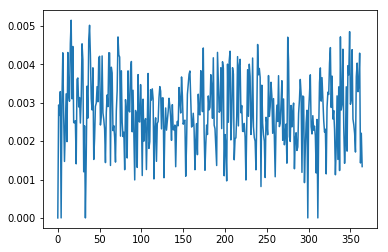

In [875]:
#daily seasonlaity index
plt.plot(si_sum['si_index'])

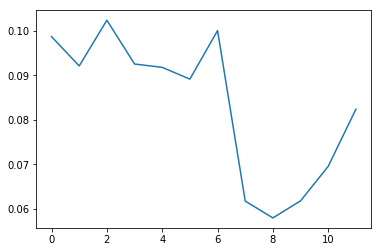

In [876]:
#monthly seasonality index
si_mth = si_sum.groupby(['month'])['Sales'].sum().reset_index()
si_mth['si_index'] = si_mth['Sales']/sum(si_mth['Sales'])
#si_mth.head()
plt.plot(si_mth['si_index'])

In the above plot the effect of seasonality can be observed by month,
* There seems to be a dip in sales during the months of August & September 
* Sales peaks during the months of January, March, July
* The dip in sales may also be caused due to the store closure during a majority of days

In [877]:
#mapping daily seasonality index to day & month in dataset
si_group = si_sum[['si_index', 'day_mth']]
store1['day_mth'] = store1['day'].astype(str)+"-"+store1['month'].astype(str)
store1.head()
store_l = store1.merge(si_group, on='day_mth', how='left')
store_l.drop('day_mth', axis=1, inplace=True)
store_l.head()


Sales  Customers  Open  Promo  StateHoliday  SchoolHoliday  year  day  \
0   5263        555     1      1             0              1  2015   31   
1   5263        555     1      1             0              1  2015   31   
2   5020        546     1      1             0              1  2015   30   
3   5020        546     1      1             0              1  2015   30   
4   4782        523     1      1             0              1  2015   29   

   iso_weeknum  weekday    ...     wc_days  num_asy_app        cpi      tmpc  \
0           31        6    ...           0 39825.000000 100.288454 16.296894   
1           31        6    ...           0 39825.000000 100.288454 16.296894   
2           31        5    ...           0 39825.000000 100.288454 15.944318   
3           31        5    ...           0 39825.000000 100.288454 15.944318   
4           31        4    ...           0 39825.000000 100.288454 16.233511   

       relh  CompetitionDistance  days_since_competition  days_since_promo2  \
0 54.272174          1270.000000                    2524                  0   
1 54.272174          1270.000000                    2524                  0   
2 56.774830          1270.000000                    2523                  0   
3 56.774830          1270.000000                    2523                  0   
4 58.021436          1270.000000                    2522                  0   

   promo2_int_mod  si_index  
0               0  0.004289  
1               0  0.004289  
2               0  0.004380  
3               0  0.004380  
4               0  0.004392  

[5 rows x 23 columns]

In [878]:
store_l= store_l[['Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday',
                  'google_svi', 'wc_days', 'num_asy_app', 'cpi', 'tmpc', 'relh',
                  'CompetitionDistance', 'days_since_competition', 'days_since_promo2',
                  'promo2_int_mod', 'si_index']]

<h3>Train, Validation & Test Split</h3><hr>

In [879]:
#splitting the data set into train and test dataset

cols = ['Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday',
        'google_svi', 'wc_days', 'num_asy_app', 'cpi', 'tmpc', 'relh',
        'CompetitionDistance', 'days_since_competition', 'days_since_promo2',
        'promo2_int_mod', 'si_index']
split = round(len(store_l)*0.2)
test_l = store_l.iloc[:split,]
train_l = store_l.iloc[split+1:,]

train_x = train_l[cols]
test_x = test_l[cols]

train_y = train_l['Sales']
test_y = test_l['Sales']

In [880]:
train_l.head()

Sales  Customers  Open  Promo  StateHoliday  SchoolHoliday  google_svi  \
378   3586        489     1      0             0              0          48   
379   3586        489     1      0             0              0          48   
380   3492        493     1      0             0              0          48   
381   3492        493     1      0             0              0          48   
382   3299        460     1      0             0              0          48   

     wc_days  num_asy_app       cpi      tmpc      relh  CompetitionDistance  \
378        0 26875.000000 98.791611  0.561783 79.959045          1270.000000   
379        0 26875.000000 98.791611  0.561783 79.959045          1270.000000   
380        0 26875.000000 98.791611  0.748428 80.800440          1270.000000   
381        0 26875.000000 98.791611  0.748428 80.800440          1270.000000   
382        0 26875.000000 98.791611 -0.537162 85.408311          1270.000000   

     days_since_competition  days_since_promo2  promo2_int_mod  si_index  
378                    2335                  0               0  0.003702  
379                    2335                  0               0  0.003702  
380                    2334                  0               0  0.003706  
381                    2334                  0               0  0.003706  
382                    2333                  0               0  0.003725

In [881]:
print("Length of train set:\t {}\nLength of test set:\t {}".format(len(train_l), len(test_l)))


Length of train set:	 1506
Length of test set:	 377


In [882]:
train.head()

Sales  Customers  Open  Promo  StateHoliday  SchoolHoliday  year  day  \
378   3586        489     1      0             0              0  2015   23   
379   3586        489     1      0             0              0  2015   23   
380   3492        493     1      0             0              0  2015   22   
381   3492        493     1      0             0              0  2015   22   
382   3299        460     1      0             0              0  2015   21   

     iso_weeknum  weekday       ...        google_svi  wc_days  num_asy_app  \
378            4        6       ...                48        0 26875.000000   
379            4        6       ...                48        0 26875.000000   
380            4        5       ...                48        0 26875.000000   
381            4        5       ...                48        0 26875.000000   
382            4        4       ...                48        0 26875.000000   

          cpi      tmpc      relh  CompetitionDistance  \
378 98.791611  0.561783 79.959045          1270.000000   
379 98.791611  0.561783 79.959045          1270.000000   
380 98.791611  0.748428 80.800440          1270.000000   
381 98.791611  0.748428 80.800440          1270.000000   
382 98.791611 -0.537162 85.408311          1270.000000   

     days_since_competition  days_since_promo2  promo2_int_mod  
378                    2335                  0               0  
379                    2335                  0               0  
380                    2334                  0               0  
381                    2334                  0               0  
382                    2333                  0               0  

[5 rows x 22 columns]

In [883]:
lreg = LinearRegression()
lmodel = lreg.fit(train_x, train_y)
pred = lreg.predict(test_x)

In [884]:
testing_l = pd.DataFrame(columns= ['test_y', 'pred'])
testing_l['test_y'] = test_y
testing_l['pred'] = pd.DataFrame(pred)
testing_l = testing_l.loc[testing_l['test_y']!=0]
testing_l = testing_l.astype(float)

In [885]:
#removing rows with 0 values from the test data since mape cannot be used on these
mape(testing_l['test_y'], testing_l['pred'])

4.59997082650432

<h3>the accuracy of the linear model of 4.59 MAPE for store 1 seems to be quite acceptable, but can be further optimized by altering the parameters </h3>

In [893]:
#printing coefficients 
coeff = pd.DataFrame(train_x.columns)
coeff['coeff_estimates'] = pd.Series(lreg.coef_)
coeff

0  coeff_estimates
0                Customers         9.740841
1                     Open      -978.274300
2                    Promo       410.918393
3             StateHoliday       -80.116345
4            SchoolHoliday        14.162310
5               google_svi        -0.242419
6                  wc_days        12.098893
7              num_asy_app         0.010487
8                      cpi       127.419502
9                     tmpc         5.343386
10                    relh         0.605306
11     CompetitionDistance         0.000000
12  days_since_competition        -0.211792
13       days_since_promo2         0.000000
14          promo2_int_mod         0.000000
15                si_index     33320.137611

There is not feature selection such as Forward, Backdard and stepwise, other options are to be explored

<h3>Forcasting (Univariate) Overall Sales using Prophet </h3><hr>

In [899]:
prop_data = copy.deepcopy(forecast_clean)
cols=['Unnamed: 0', 'Store', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'year', 'day', 'iso_weeknum',
       'weekday', 'month', 'quarter', 'mapped_region', 'google_svi', 'wc_days',
       'num_asy_app', 'cpi', 'tmpc', 'relh', 'CompetitionDistance',
       'days_since_competition', 'days_since_promo2', 'promo2_int_mod']

prop_data.drop(cols, axis=1, inplace=True)


In [900]:
prop_data = prop_data.groupby(['date_s']).sum().reset_index()

In [907]:
#input column names should be 'ds' and 'y'
prop_data.columns = ['ds', 'y']
prop_data['ds']= pd.to_datetime(prop_data['ds'])
#prop_data.set_index('ds', inplace=True)
prop_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 942 entries, 0 to 941
Data columns (total 2 columns):
ds    942 non-null datetime64[ns]
y     942 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 14.8 KB


In [928]:
split = round(len(prop_data)*0.8)
train = prop_data.iloc[:split,]
test = prop_data.iloc[split:,]

In [929]:
print('Length of train: {}\nLength of test: {}'.format(len(train), len(test)))

Length of train: 754
Length of test: 188


In [930]:
#fitting data to prophet model
m = Prophet(daily_seasonality=True)
m.fit(train);
train.tail()

ds         y
749 2015-01-20  14921324
750 2015-01-21  15294612
751 2015-01-22  15482339
752 2015-01-23  16544384
753 2015-01-24  15696085

In [933]:
test.head()

ds         y
754 2015-01-25    379600
755 2015-01-26  24685584
756 2015-01-27  21588152
757 2015-01-28  20830443
758 2015-01-29  20965889

In [934]:
#making prediction to 15 days ahead
future = m.make_future_dataframe(periods=188, freq='D')
forecast = m.predict(future)

In [935]:
forecast.columns

Index(['ds', 'trend', 'trend_lower', 'trend_upper', 'yhat_lower', 'yhat_upper',
       'daily', 'daily_lower', 'daily_upper', 'seasonal', 'seasonal_lower',
       'seasonal_upper', 'seasonalities', 'seasonalities_lower',
       'seasonalities_upper', 'weekly', 'weekly_lower', 'weekly_upper',
       'yearly', 'yearly_lower', 'yearly_upper', 'yhat'],
      dtype='object')

In [936]:
fore = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

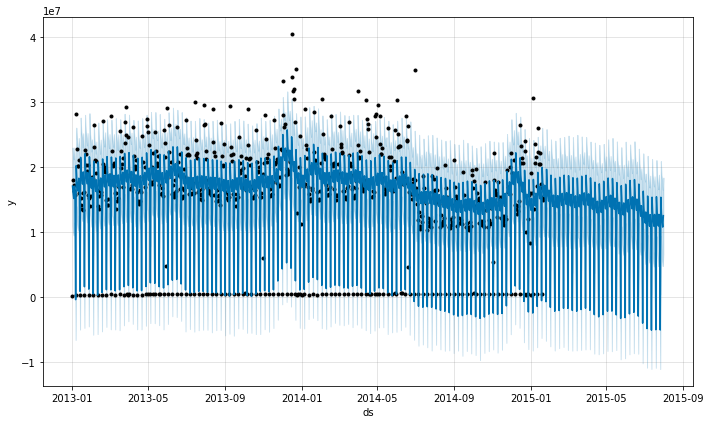

In [937]:
#get the data at a higher level to get a line plot
m.plot(fore);

In [938]:
act = test
predicted = forecast

In [955]:
#calculating needs to checked for prophet
mape(prop_data['y'], predicted['yhat'])

180.98710125246802

In [950]:
predicted[['ds', 'yhat']].tail()

ds            yhat
937 2015-07-27 15315206.564828
938 2015-07-28 12824742.032223
939 2015-07-29 11661556.685266
940 2015-07-30 10721476.901343
941 2015-07-31 12482665.963311

In [940]:
act.head()

ds         y
754 2015-01-25    379600
755 2015-01-26  24685584
756 2015-01-27  21588152
757 2015-01-28  20830443
758 2015-01-29  20965889

<div style="background-color:#7a1400;height:40px;padding-top:0.1px;">
<h6 align=center style="color:white">
<a href="https://www.linkedin.com/in/avinashpasupulate/" style="color:white">Avinash Pasupulate - Linkedin Profile</a>
</h6> 
</div>